WRITE A DESCRIPTION

In [381]:
#! pip install simpy
#import simpy
#! pip install numpy
#import numpy as np
#! pip install seaborn
#import seaborn as sns
#import matplotlib.pyplot as plt
#import pandas as pd
#import random
#from IPython.display import display

In [382]:
class Scheduler:

    def __init__(self, environment, type):

        self.environment = environment
        self.type = type
        self.pending_tasks = []
        self.incomplete_tasks= []
        self.completed_tasks = []
        self.task_id_counter = 0
        self.current_task = None
        
        if type == "RANDOM":
            self.environment.process(self.process_randomly(self.environment))
        elif type == "FIFO":
            self.environment.process(self.process_fifo(self.environment))
        elif type == "LIFO":
            self.environment.process(self.process_lifo(self.environment))
        elif type == "EDF":
            self.environment.process(self.process_edf(self.environment))
        else:
            print("Incorrect scheduling type... choose from: RANDOM, FIFO, LIFO or EDF")

    def process_randomly(self, environment):
        while True:
            if self.pending_tasks:
                next_task = random.choice(self.pending_tasks)
                yield environment.process(next_task.process())
            else:
                yield environment.timeout(1)

    def process_fifo(self, environment):
         while True:
            if self.pending_tasks:
                 next_task = self.pending_tasks[0]
                 yield environment.process(next_task.process())
            else:
                yield environment.timeout(1)

    def process_lifo(self, environment):
        while True:
            if self.pending_tasks:
                next_task = self.pending_tasks.pop()
                yield environment.process(next_task.process())
            else:
                yield environment.timeout(1) 

    def process_edf(self, environment):

        current_task_process = None
        highest_priority_task = None
        
        while True:
            
            if self.pending_tasks:

                if(self.current_task == None):
                    self.current_task = min(self.pending_tasks, key = lambda x: x.priority)
                    current_task_process = environment.process(self.current_task.process())

                highest_priority_task = min(self.pending_tasks, key = lambda x: x.priority)
                
                if self.current_task != highest_priority_task and self.current_task.priority > highest_priority_task.priority:
                    #make sure to only interrupt if the task is not complete (temporaty bug fix)
                    #print(f"better task exists @ time {environment.now}")
                    #if environment.now - self.current_task.start != self.current_task.duration:
                    print(f"Interrupting Task {self.current_task.id} for Task {highest_priority_task.id} at {environment.now}")
                    interrupt_cause = simpy.Interrupt(current_task_process)
                    interrupt_cause.usage_since = environment.now
                    current_task_process.interrupt(interrupt_cause)
                    self.current_task = highest_priority_task
                    current_task_process = environment.process(self.current_task.process())

                yield environment.timeout(1)
                
            else:
                yield environment.timeout(1)
            
  #  def process_oracle():

In [383]:
class Task:

    def __init__(self, id, priority, duration, vehicle, environment):

        self.id = id
        self.priority = priority
        self.duration = duration
        self.vehicle = vehicle
        self.environment = environment

        self.time_spent_processing = 0
        self.start = None 
        self.vehicle.assigned_tasks.append(self)
        self.vehicle.scheduler.task_id_counter += 1
        self.vehicle.scheduler.pending_tasks.append(self)

        print(f'Vehicle {self.vehicle.id} generated a new Task at {self.environment.now} - new Task id:{self.id}, priority: {self.priority} and duration: {self.duration}')

    def process(self):
        try:
            self.start = self.environment.now
            print(f'Task {self.id} started processing at {self.start}')
            if self not in self.vehicle.scheduler.incomplete_tasks:
                self.vehicle.scheduler.incomplete_tasks.append(self)
            if self in self.vehicle.scheduler.pending_tasks:
                self.vehicle.scheduler.pending_tasks.remove(self)
            

            #try to timeout for the time needed to complete the task
            yield self.environment.timeout(self.duration - self.time_spent_processing) 
            print(f'Task {self.id} completed at {self.environment.now}')
            self.vehicle.scheduler.current_task = None
            
            self.vehicle.completed_tasks.append(self)   #or do this with scheduler processed tasks
            self.vehicle.scheduler.incomplete_tasks.remove(self)
            if self not in self.vehicle.scheduler.completed_tasks:
                self.vehicle.scheduler.completed_tasks.append(self)

        except simpy.Interrupt as interrupt:
            usage = interrupt.cause.usage_since - self.start 
            #save the processing progress of the task
            self.time_spent_processing += usage
            if self not in self.vehicle.scheduler.pending_tasks:
                self.vehicle.scheduler.pending_tasks.append(self)

            print(f'Task {self.id} got preempted at {self.environment.now} after running for {usage}')

In [384]:
class Vehicle:

    def __init__(self, id, environment, assigned_tasks, lambda_tasks, lambda_dwell_time, scheduler, generator):

        self.id = id
        self.environment = environment
        self.assigned_tasks = assigned_tasks
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time   
        self.scheduler = scheduler
        self.generator = generator

        self.completed_tasks = []
        self.inROI = True

        print(f'Vehicle {self.id} spawned in environment at time {self.environment.now}')
        self.generator.vehicles.append(self)
        self.generator.vehicles_present.append(self)

        #start lifecycle of every task that is created before simulation
        for task in assigned_tasks:     
            self.scheduler.task_id_counter += 1          
            self.scheduler.pending_tasks.append(task)

        #schedule departure
        self.environment.process(self.scheduleDeparture(self.environment))
        #start task generator
        self.environment.process(self.generateTasks())

    def scheduleDeparture(self, environment):
        yield environment.timeout(np.random.poisson(self.lambda_dwell_time))
        self.inROI = False

    def generateTasks(self):

        while self.inROI:

            priority = random.randint(0, 5)
            duration = random.randint(1, 5)
            yield self.environment.timeout(np.random.poisson(self.lambda_tasks)) 
            new_task = Task(self.scheduler.task_id_counter, priority, duration, self, self.environment)
           
        self.generator.vehicles_present.remove(self)
        self.generator.vehicles_departed.append(self)

        print(f"vehicle {self.id} left the intersection and stopped generating tasks at {self.environment.now}")

In [385]:
class VehicleGenerator:

    def __init__(self, lambda_vehicles, lambda_tasks, lambda_dwell_time, environment, scheduler, generate):

        self.lambda_vehicles = lambda_vehicles
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time
        self.environment = environment
        self.scheduler = scheduler
        self.generate = generate

        self.vehicles = []
        self.vehicles_present = []
        self.vehicles_departed = []

        if self.generate:
            self.environment.process(self.generateVehicles(self.environment))
    
    def tasks_generated(self):
        counter = 0
        for vehicle in self.vehicles:
            counter += len(vehicle.assigned_tasks)
        return counter
    
    def mean_tasks_completed_per_vehicle(self):
        sum = 0
        if len(self.vehicles) == 0: return 0

        for v in self.vehicles:      
            if len(v.assigned_tasks) != 0:
                sum += len(v.completed_tasks)/len(v.assigned_tasks)
            else: 
                sum += 0
        mean = (sum/len(self.vehicles)) * 100
        return mean
    
    def time_spent_processing(self):
        result = []

        for v in self.vehicles:
            v_processing_time = 0
            incomplete_tasks = [t for t in v.assigned_tasks if t not in v.completed_tasks]
            #processing time of all completed tasks
            for t in v.completed_tasks:
                v_processing_time += t.duration
            #processing time of all incomplete tasks
            for t in incomplete_tasks:
                v_processing_time += t.time_spent_processing
            result.append(v_processing_time)    
                
        #should hold the time spent processing for each vehicle   
        return result 
    
    def scheduling_type(self):
        result = []
        for v in self.vehicles:
            result.append(v.scheduler.type)
        return result
        
    def generateVehicles(self, environment):
        while True:
             timeout = np.random.poisson(self.lambda_vehicles)
             yield environment.timeout(timeout)
             new_vehicle = Vehicle(len(self.vehicles), environment, [], self.lambda_tasks, self.lambda_dwell_time, self.scheduler, self)

In [386]:
simulation_data = pd.DataFrame(columns=['scheduling type', 'total vehicles generated',
                                        'vehicles present', 'vehicles departed',
                                        'total tasks generated', 'total tasks completed', 
                                        'total tasks completed percentage', 
                                        'avg. tasks completed per vehicle', 'incomplete tasks'])

processing_time = None
mean_processing_time = None

#run simulation once for each scheduling type
def run_sim(sim_seed, scheduling_type, poisson_vehicles, poisson_tasks, poisson_dwell_time, sim_end_time, generate):

   #simulation data to be collected

   global simulation_data
   global processing_time
   global mean_processing_time

   pt_scheduling_type = []
   total_processing_time_of_vehicle = []

   index = 0
   for type in scheduling_type:

      random.seed(sim_seed)
      np.random.seed(sim_seed)
        
      #run simulation
      intersection = simpy.Environment()
      scheduler = Scheduler(intersection, type)
      vehicle_generator = VehicleGenerator(poisson_vehicles, poisson_tasks, poisson_dwell_time, intersection, scheduler, generate)
      print(50*"=")
      print(f"SCHEDULER: {scheduler.type}")
      intersection.run(until = sim_end_time)
      print(50*"=")
      print(f"total vehicles spawned: {len(vehicle_generator.vehicles)}")
      print(f"total tasks generated: {vehicle_generator.tasks_generated()}")

      pt_scheduling_type.append(vehicle_generator.scheduling_type())
      total_processing_time_of_vehicle.append(vehicle_generator.time_spent_processing())

      simulation_data.loc[index] = [type, len(vehicle_generator.vehicles),len(vehicle_generator.vehicles_present),len(vehicle_generator.vehicles_departed), vehicle_generator.tasks_generated(), len(scheduler.completed_tasks), len(scheduler.completed_tasks)/vehicle_generator.tasks_generated() * 100 if vehicle_generator.tasks_generated() != 0 else 0, vehicle_generator.mean_tasks_completed_per_vehicle(), len(scheduler.incomplete_tasks)]
      index += 1

   #for the scatter plot
   pt_scheduling_type = np.concatenate(pt_scheduling_type).ravel().tolist()
   total_processing_time_of_vehicle = np.concatenate(total_processing_time_of_vehicle).ravel().tolist()

   pt = pd.DataFrame({
      "scheduling type" : pt_scheduling_type,
      "total processing time of vehicle" : total_processing_time_of_vehicle,
   })

   processing_time = pt

   mean_processing_time = pt.groupby('scheduling type')['total processing time of vehicle'].agg(['mean', 'sum']).reset_index()
   mean_processing_time['mean'] = mean_processing_time['mean'].round(1)


In [387]:
run_sim(sim_seed = 42, scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF'], poisson_vehicles = 3, poisson_tasks = 5, poisson_dwell_time = 15, sim_end_time = 30, generate = True)
display(simulation_data)
#display(processing_time)

SCHEDULER: RANDOM
Vehicle 0 spawned in environment at time 4
Vehicle 1 spawned in environment at time 5
Vehicle 2 spawned in environment at time 6
Vehicle 0 generated a new Task at 8 - new Task id:0, priority: 5 and duration: 1
Vehicle 2 generated a new Task at 8 - new Task id:1, priority: 1 and duration: 2
Task 0 started processing at 8
Vehicle 1 generated a new Task at 9 - new Task id:2, priority: 0 and duration: 3
Vehicle 3 spawned in environment at time 9
Task 0 completed at 9
Task 1 started processing at 9
Task 1 completed at 11
Task 2 started processing at 11
Vehicle 2 generated a new Task at 12 - new Task id:3, priority: 5 and duration: 5
Vehicle 0 generated a new Task at 13 - new Task id:4, priority: 1 and duration: 1
Vehicle 3 generated a new Task at 14 - new Task id:5, priority: 0 and duration: 1
Task 2 completed at 14
Task 5 started processing at 14
Vehicle 1 generated a new Task at 15 - new Task id:6, priority: 4 and duration: 4
Vehicle 4 spawned in environment at time 15
V

,scheduling type,total vehicles generated,vehicles present,vehicles departed,total tasks generated,total tasks completed,total tasks completed percentage,avg. tasks completed per vehicle,incomplete tasks
0,RANDOM,9,5,4,24,8,33.333333,31.851852,1
1,FIFO,9,5,4,24,9,37.500000,25.185185,1
2,LIFO,9,5,4,24,9,37.500000,24.814815,1
3,EDF,9,5,4,24,5,20.833333,14.814815,2


/var/folders/hy/5wx09kc90jn235gj04l9s87w0000gn/T/ipykernel_23130/3179518128.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=processing_time, x='scheduling type', y='total processing time of vehicle', ax=axes[1, 1],hue = 'scheduling type', palette=pastel_colors)


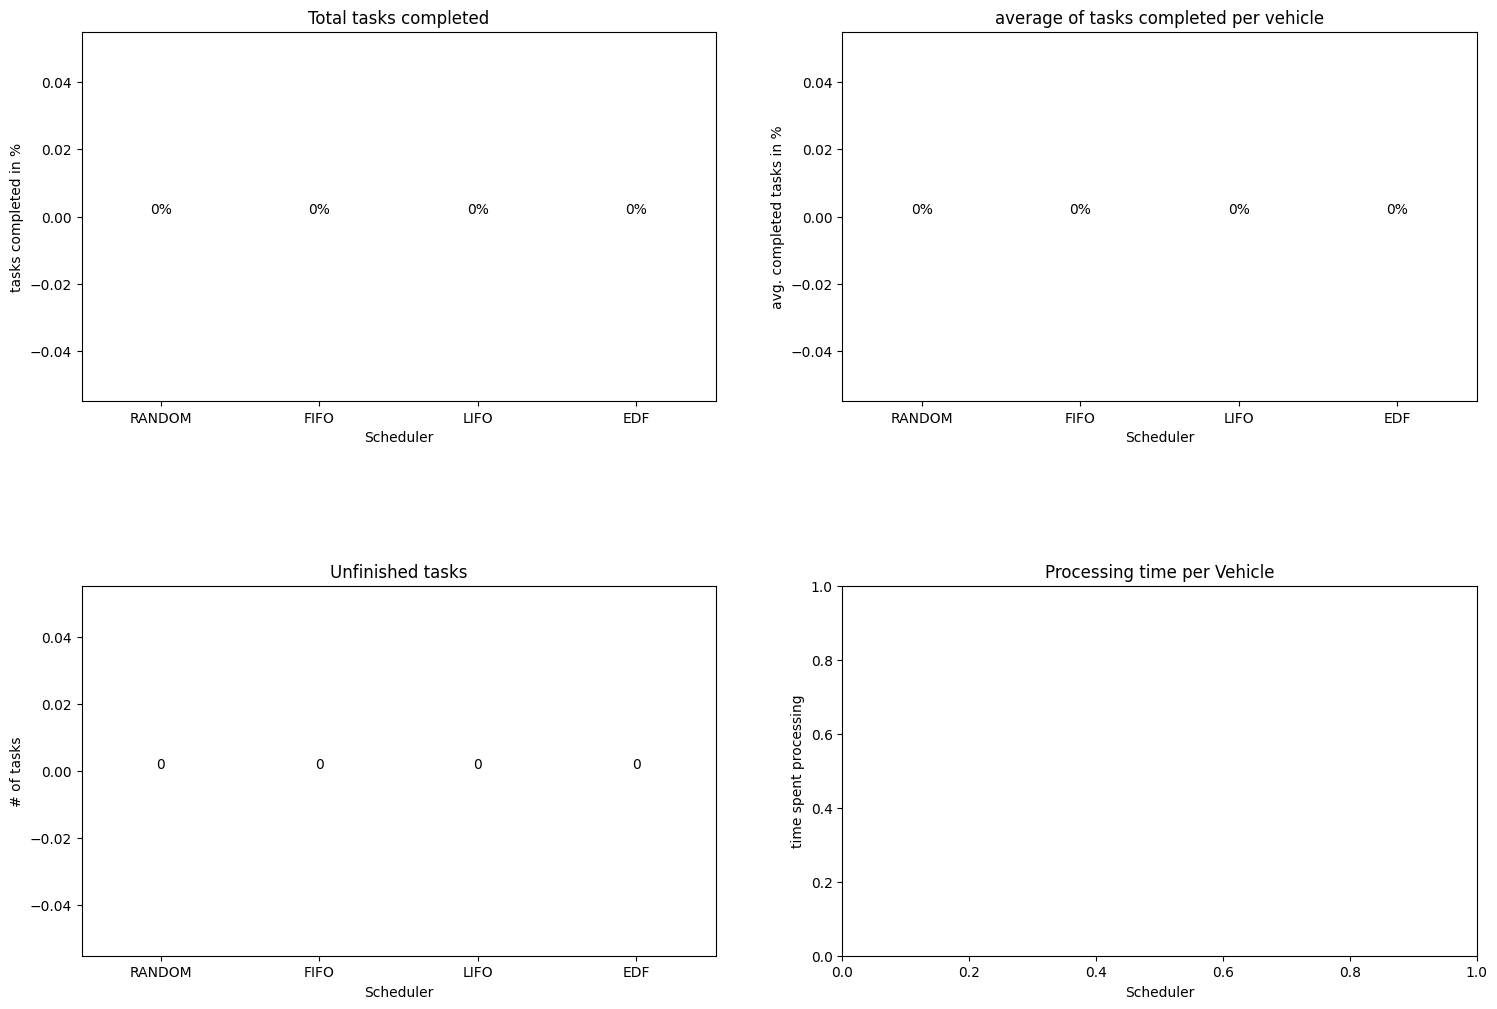

In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)

# Define pastel colors
pastel_colors = ['#FFB6C1', '#FFD700', '#98FB98', '#ADD8E6']

# Plot 1
sns.barplot(x=scheduling_type, y=simulation_data['total tasks completed percentage'], ax=axes[0, 0], hue=scheduling_type, palette=pastel_colors)
axes[0, 0].set_title('Total tasks completed')
axes[0, 0].set_xlabel('Scheduler')
axes[0, 0].set_ylabel('tasks completed in %')

# Plot 2
sns.barplot(x=scheduling_type, y=simulation_data['avg. tasks completed per vehicle'], ax=axes[0, 1], hue=scheduling_type, palette=pastel_colors)
axes[0, 1].set_title('average of tasks completed per vehicle')
axes[0, 1].set_xlabel('Scheduler')
axes[0, 1].set_ylabel('avg. completed tasks in %')

# Plot 3
sns.barplot(x=scheduling_type, y=simulation_data['incomplete tasks'], ax=axes[1, 0], hue=scheduling_type, palette=pastel_colors)
axes[1, 0].set_title('Unfinished tasks')
axes[1, 0].set_xlabel('Scheduler')
axes[1, 0].set_ylabel('# of tasks')

# plot 4
sns.scatterplot(data=processing_time, x='scheduling type', y='total processing time of vehicle', ax=axes[1, 1],hue = 'scheduling type', palette=pastel_colors)
axes[1,1].set_title('Processing time per Vehicle')
axes[1,1].set_xlabel('Scheduler')
axes[1,1].set_ylabel('time spent processing')

#labeling the plots
for index, value in enumerate(simulation_data['total tasks completed percentage']):
    axes[0, 0].text(index, value, f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['avg. tasks completed per vehicle']):
    axes[0, 1].text(index, value,f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['incomplete tasks']):
    axes[1, 0].text(index, value, str(value), ha='center', va='bottom')

# Add mean as separate points
for index, row in mean_processing_time.iterrows():
    mean = row['mean']
    total = row['sum']
    axes[1, 1].scatter(row['scheduling type'], mean, color='black', marker='_', s=100)
    axes[1, 1].text(row['scheduling type'], mean, f'Mean: {mean}', ha='center', va='bottom')

plt.show()